# Multi-Frame Motion Deblur Recovery
This notebook opens .npz simulation data file, addes noise, and solved inverse problem

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import time
import sys
import itertools
import math
import imageio
import skimage as sk

# Libwallerlab imports
from libwallerlab.algorithms import iterative as iterative
from libwallerlab.opticsalgorithms.motiondeblur import blurkernel 
from libwallerlab.opticsalgorithms.motiondeblur import kernel_objectives 
from libwallerlab.operators import operators as ops
from libwallerlab.utilities import displaytools, iotools

from libwallerlab.algorithms import objectivefunctions
from libwallerlab.algorithms import regularizers
from libwallerlab.operators import proximal as proxops
from libwallerlab.utilities.opticstools import Ft, iFt

## Flow of Notebook
1. Open .npz datafile (from simulation notebook)
2. Solve Inverse Problem
3. View blur paths, estimated conditioning, SSE

### To-Do
- make compatible with libwallerlab.utilities.iotools.Dataset format

In [2]:
noise_magnitude = 1e-3

noise_type = 'shot'

savepath = '/home/sarah/Dropbox/deblurring/COSI/data/simulations/recovered'

# Open Datafile

In [35]:
# directory and name of file of interest
datafile_dir = '/home/sarah/Dropbox/deblurring/COSI/data/simulations/blurred'
filename = 'raster_pseudo_random_9x1' #'raster_major_both_random_phase_18x1'

# load data and assign variables
data = np.load(datafile_dir + '/' + filename + '.npz')
#np.savez(savestring, object_true=object_true, image_size=image_size, object_edge_pad_type=object_edge_pad_type, point_list_segmented=point_list_segmented, illum_vector_list=illum_vector_list, y_list=y_list)

# Add Noise and View Images

/home/sarah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


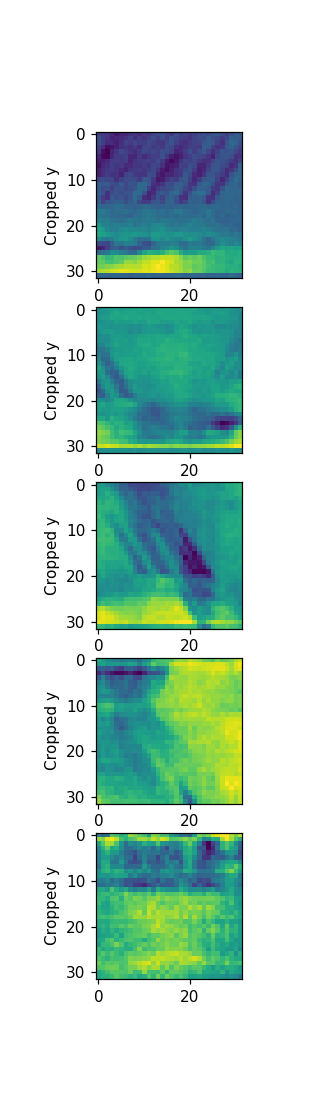

In [4]:
image_size = data['image_size']
y_list_pure = data['y_list']

y_list = []
for y in y_list_pure:
    noise = noise_magnitude * np.random.normal(size=y.shape)
    if noise_type == 'shot': noise = noise * y
    y_list.append((y + noise).astype(np.float32))

nshow = min(5,len(y_list))
plt.figure(figsize=(3,nshow*2))
for i in range(nshow):  
    plt.subplot(nshow, 1, i+1)
    plt.imshow(np.abs(y_list[i].reshape(image_size)))
    plt.ylabel('Cropped y')

# Recreate Blur Paths

<IPython.core.display.Javascript object>


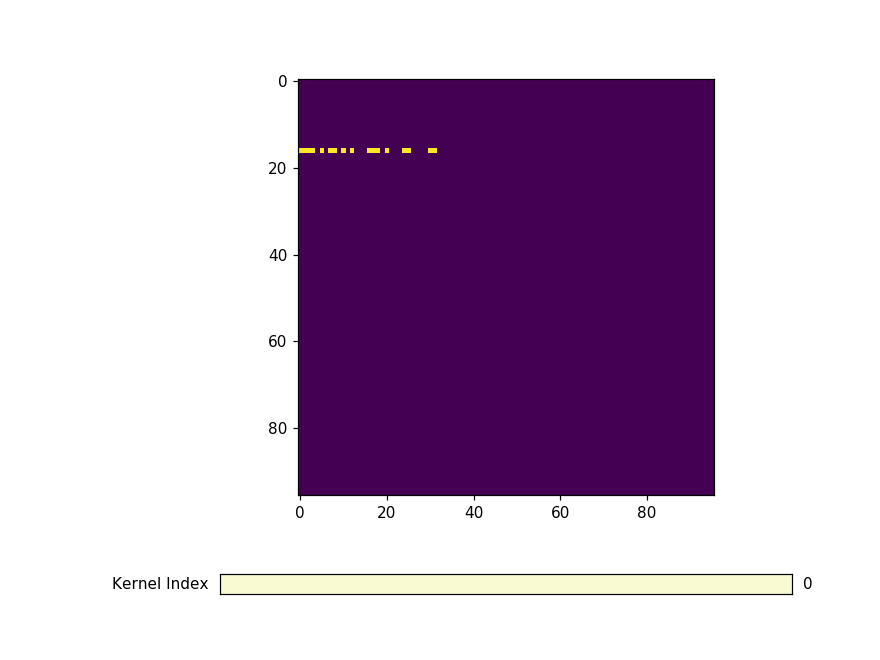

/home/sarah/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [5]:
# Generate blur kernel maps for each frame
object_size_0 = data['object_true'].shape
illum_vector_list = data['illum_vector_list']
point_list_segmented = data['point_list_segmented']

blur_kernel_list = np.zeros((len(point_list_segmented), object_size_0[0], object_size_0[1]))
for frame_index in range(len(illum_vector_list)):
    for position_index, position in enumerate(point_list_segmented[frame_index]):
        blur_kernel_list[frame_index, position[0], position[1]] = illum_vector_list[frame_index][position_index]

# Define cropped object sizes and crop true image
object_size = blur_kernel_list[0].shape

# Show blur kernels
displaytools.show3dArray(blur_kernel_list, figsize=(8,6))

# Forward model based on Padding and Blur Kernels

In [6]:
# Determine maximum kernel support in x/y for all blur kernels in blur_kernel_list. This is how much we will pad our object by.
support_size_list = []
for blur_kernel in blur_kernel_list:
    support_size_list.append(blurkernel.getPositionListBoundingBox(point_list_segmented).size())
max_kernel_support = np.max(np.asarray(support_size_list),axis=0)

# Generate pad operator for object support
object_size_padded = (np.asarray(object_size) + max_kernel_support).tolist() # Add to object_size
W_object_support = ops.Crop(object_size_padded, object_size, crop_start=(max_kernel_support[0] // 2, max_kernel_support[1] // 2)) # Add support

# Pad object with random values (to simulate an extended object)
object_true = data['object_true']
object_extended = W_object_support.H * object_true.reshape(-1).astype(np.complex64)
object_edge_pad_type = data['object_edge_pad_type']
if object_edge_pad_type == 'random':
    object_extended += (1. - W_object_support.H * np.ones(object_true.size, dtype=np.complex64)) * np.random.rand(np.prod(object_size_padded))
elif object_edge_pad_type == 'zeros':
    object_extended += (1. - W_object_support.H * np.zeros(object_true.size, dtype=np.complex64))
elif object_edge_pad_type == 'ones':
    object_extended += (1. - W_object_support.H * np.ones(object_true.size, dtype=np.complex64))
elif object_edge_pad_type == 'mean':
    object_extended += (1. - W_object_support.H * np.mean(object_true) * np.ones(object_true.size, dtype=np.complex64))
elif object_edge_pad_type == None:
    object_extended = object_true
    object_size_padded = object_true.shape
    W_object_support = ops.Identity(object_true.shape)
    
# Define crop operator for object to image
W = ops.Crop(object_size, image_size)

A_list = []

# Generate forward model operators for each blur kernel
for blur_kernel_index, blur_kernel in enumerate(blur_kernel_list):
    blur_kernel = blur_kernel.astype(np.complex64) / np.sum(np.abs(blur_kernel.astype(np.complex64)))
    
    # 2D Convolution Operator with the given kernel
    C = ops.Convolution(object_size_padded, (W_object_support.H * blur_kernel.reshape(-1)).reshape(object_size_padded))
    
    # Forward operator with image crop and full object crop
    A_list.append(W * W_object_support * C)

# Recovery

In [7]:
# Generate measurements from image list
y_full = np.empty(0, dtype=np.complex64)
for y in y_list:
    y_full = np.append(y_full, y)
    
# Normalize measurements
y_mean = np.mean(np.abs(y_full))  
y_full /= y_mean

# Generate full A Operator
A_full = ops.Vstack(Operators=A_list)

# Initialization: choosing a "good" coefficient value will help in convergence
initialization = np.ones(object_size_padded, dtype=np.complex64).reshape(-1)

# Define cost function
objective = objectivefunctions.L2(A_full, y_full)

solve_method = 'cg'
display_type = 'text'
# Solve linear inverse problem

if solve_method is 'gd':
    iteration_count = 3000
    object_recovered = iterative.GradientDescent(objective).solve(initialization=initialization, 
                                                                  step_size=1,
                                                                  iteration_count=iteration_count, 
                                                                  display_type=display_type, 
                                                                  display_iteration_delta=(iteration_count // 10))
elif solve_method is 'cg':
    iteration_count = 500
    object_recovered = iterative.ConjugateGradient(A_full, y_full).solve(initialization=initialization, 
                                                                  iteration_count=iteration_count, 
                                                                  display_type=display_type,
                                                                  use_log_y=False,
                                                                  use_log_x=False,
                                                                  debug=True,
                                                                  display_iteration_delta=(iteration_count // 10))
elif solve_method is 'fista':
    iteration_count = 300

    object_recovered = iterative.Fista(objective, proximal_operator=proxops.positivity).solve(initialization=initialization, 
                                                                                              iteration_count=iteration_count, 
                                                                                              display_type=display_type,
                                                                                              use_log_y=True,
                                                                                              use_log_x=False,
                                                                                              debug=True,
                                                                                              display_iteration_delta=(iteration_count // 10))

|  Iter  |      Cost      | Elapsed time (sec) |
+ ------ + -------------- + ------------------ +
|    0   |    1.07e+00    |        0.00        |
|   50   |    3.35e-04    |        4.34        |
|  100   |    1.77e-04    |        8.43        |
|  150   |    1.26e-04    |       12.63        |
|  200   |    1.03e-04    |       17.39        |
|  250   |    8.66e-05    |       21.72        |
|  300   |    7.41e-05    |       26.11        |
|  350   |    6.52e-05    |       30.62        |
|  400   |    5.85e-05    |       35.59        |
|  450   |    5.26e-05    |       40.58        |
|  500   |    4.78e-05    |       45.17        |


In [8]:
niterations = 500

Recovery SSE is 17.41


<IPython.core.display.Javascript object>


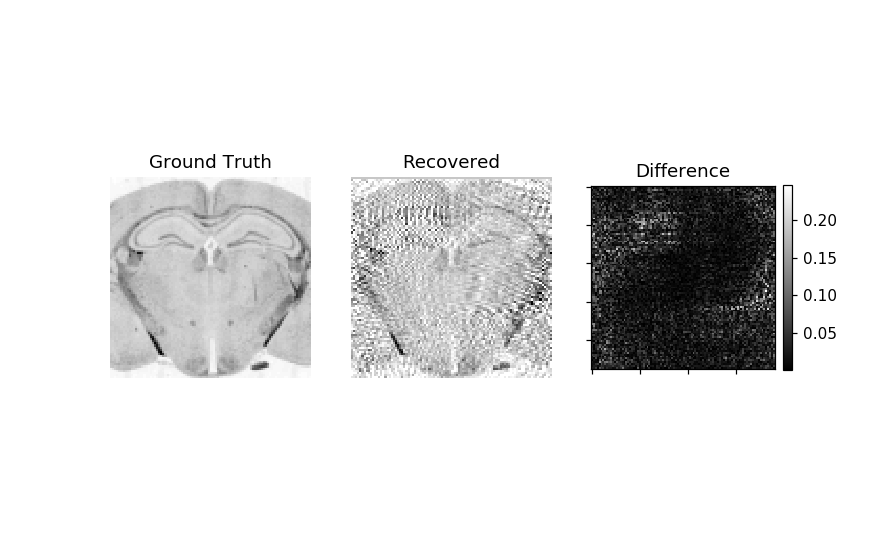

In [9]:
object_recovered_crop = (W_object_support * object_recovered).reshape(object_size)

# normalize true object (because zero-frequency is irrelevent and recon is zero-mean)
object_true_normalized = object_true / np.mean(object_true)

# Calculate SSE
SSE = np.sum(np.abs(object_true_normalized - object_recovered_crop) ** 2)
print('Recovery SSE is %.2f' % SSE)

plt.figure(figsize=[8,5]); 

plt.subplot(1,3,1); i_true = plt.imshow(np.abs(object_true_normalized), cmap='gray'); plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1,3,2); i_rec = plt.imshow(np.abs(object_recovered_crop), cmap='gray'); plt.title('Recovered'); 
i_rec.set_clim(i_true.get_clim())
plt.axis('off')
#plt.savefig("test.png", bbox_inches='tight')

ax = plt.subplot(1,3,3); plt.imshow(np.abs(object_true_normalized - object_recovered_crop), cmap='gray'); 
plt.colorbar(fraction=0.046, pad=0.04); plt.title('Difference')
ax.tick_params(labelbottom='off',labelleft='off')    


In [42]:
import os

if not os.path.exists(savepath + '/' + filename):
    os.makedirs(savepath + '/' + filename)
        
# csv or text file with noise, convergence rate, sse
with open(savepath + '/' + filename + '/recovery.txt', "w") as text_file:
    print("noise: {}\t{}\niterations: {}\nsse: {}".format(noise_type, noise_magnitude, niterations, SSE), file=text_file)

# npz file with recovered
np.savez(savepath + '/' + filename + '/recovered', object_recovered=object_recovered_crop)
